In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker

In [3]:
sheet_url = "https://docs.google.com/spreadsheets/d/1kghrW2qPYCa1wl7BIJgA08mrS2MkUelfn1SocL1jWDk/export?format=csv&gid=99527460"
df_ads = pd.read_csv(sheet_url, keep_default_na=False, decimal=",")
df_ads.head()

,install_date,country_code,media_source,spend_usd,subscribers,erevenue_12month_usd
0,2020-12-28,AD,ms_1,0.070004,0,0.00000
1,2020-12-28,AE,ms_1,33.681845,1,27.99300
2,2020-12-28,AE,ms_2,10.449999,1,6.74706
3,2020-12-28,AF,ms_1,1.460100,0,0.00000
4,2020-12-28,AG,ms_1,0.190010,0,0.00000


Прорахуємо показники, для того щоб оцінити результат від інвестицій в медіа: ROI, CPI та ARPU


In [4]:
df_agg = df_ads.groupby(["country_code", "media_source"]).agg(
    spend_usd=("spend_usd", "sum"),
    subscribers=("subscribers", "sum"),
    revenue=("erevenue_12month_usd", "sum")
).reset_index()
df_agg["ROI"]  = (df_agg["revenue"] / df_agg["spend_usd"].replace(0, np.nan)).replace([np.inf, -np.inf], 0).fillna(0)
df_agg["CPI"]  = (df_agg["spend_usd"] / df_agg["subscribers"].replace(0, np.nan)).replace([np.inf, -np.inf], 0).fillna(0)
df_agg["ARPU"] = (df_agg["revenue"] / df_agg["subscribers"].replace(0, np.nan)).replace([np.inf, -np.inf], 0).fillna(0)

Якщо ROI > 1,5 - це гарний показник, можна маштабувати закупівлю і збільшувати бюджет,


якщо ROI < 1 - це означає що ми витрачаємо на рекламу менше ніж вона приносить доходу, такого характеру закупівлі потрібно припиняти,

якщо ROI > 1 та < 1,5 - витрати потрібно оптимізовувати, шукати дешевших трафік, підбирати креативи тощо

In [5]:
df_pivot = df_agg.pivot_table(
    index="country_code",
    columns="media_source",
    values=["spend_usd", "subscribers", "revenue", "ROI", "CPI", "ARPU"],
    fill_value=0
).reset_index()

df_pivot.columns = ["_".join(col).strip("_") for col in df_pivot.columns.values]
df_pivot["total_spend"] = (df_pivot["spend_usd_ms_1"] + df_pivot["spend_usd_ms_2"] + df_pivot["spend_usd_ms_3"])

In [6]:
df_low_roi = df_pivot[
    (df_pivot["ROI_ms_1"] < 1) & 
    (df_pivot["ROI_ms_2"] < 1) &
    (df_pivot["ROI_ms_3"] < 1) &
    (df_pivot["total_spend"] > 0)
]
df_low_roi[['country_code', 'total_spend', 'ROI_ms_1', 'ROI_ms_2','ROI_ms_3']].sort_values(by="total_spend", ascending=False).head(10)

,country_code,total_spend,ROI_ms_1,ROI_ms_2,ROI_ms_3
92,IN,1167.665420,0.669479,0.000000,0.0
173,RU,638.164108,0.581017,0.000000,0.0
178,SE,620.360396,0.398335,0.000000,0.0
64,FR,453.876821,0.476569,0.602367,0.0
89,IE,395.377152,0.954686,0.665690,0.0
83,HK,247.167689,0.310726,0.000000,0.0
57,ES,209.689446,0.733203,0.830478,0.0
162,PL,205.551111,0.999984,0.000000,0.0
164,PR,189.168911,0.714909,0.390360,0.0
42,CO,182.472976,0.813862,0.000000,0.0


Ми визначили країни в яких ROI від будь якого медіа сорсу менше одиниці

В таких країнах варто відмовитись від витрат на рекламу в тому форматі в якому він зараз присутній.

Якщо країни потенційно цікаві можливо варто змінювати медіа, креативи, проводити додаткові дослідження або збільшувати бюджет

Відмова від інвестицій в ці країни дозволить вивільнити 6556 дол, це близько 10% загального бюджету.

In [7]:
df_high_roi = df_pivot[~df_pivot.index.isin(df_low_roi.index)]

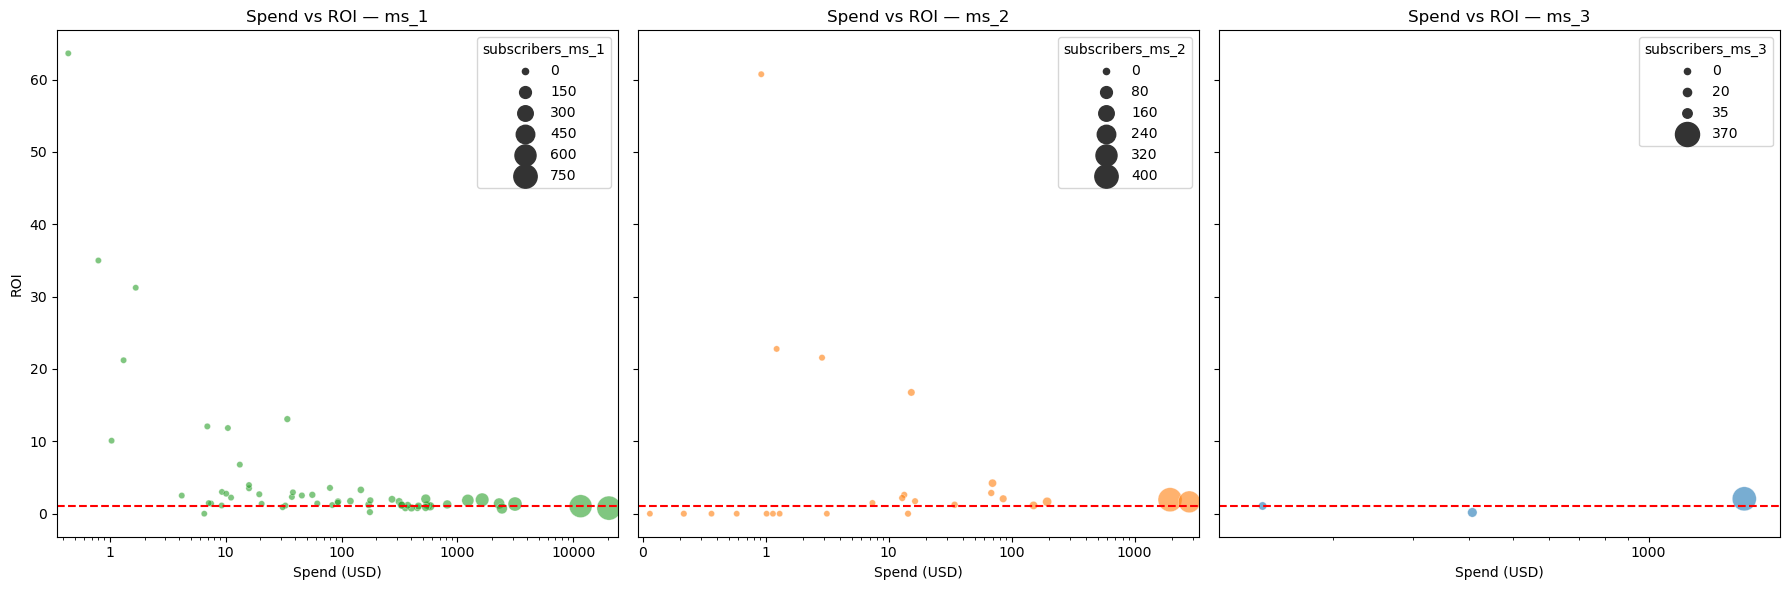

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(18,6), sharey=True)
palette = {"ms_1": "tab:green", "ms_2": "tab:orange", "ms_3": "tab:blue"}

for i, ms in enumerate(["ms_1", "ms_2", "ms_3"]):
    ax = axes[i]

    # малюємо точки
    sns.scatterplot(
        data=df_high_roi,
        x=f"spend_usd_{ms}",
        y=f"ROI_{ms}",
        size=f"subscribers_{ms}",
        sizes=(20,300),
        alpha=0.6,
        color=palette[ms],
        ax=ax
    )

    ax.axhline(1, color="red", linestyle="--")

    min_spend = df_high_roi[f"spend_usd_{ms}"].replace(0, np.nan).min()
    max_spend = df_high_roi[f"spend_usd_{ms}"].max()
    ax.set_xlim(min_spend * 0.8, max_spend * 1.2)

    ax.set_title(f"Spend vs ROI — {ms}")
    ax.set_xlabel("Spend (USD)")
    ax.set_ylabel("ROI")

    ax.set_xscale("log")
    ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.xaxis.set_minor_formatter(mticker.NullFormatter())

plt.tight_layout()
plt.show()


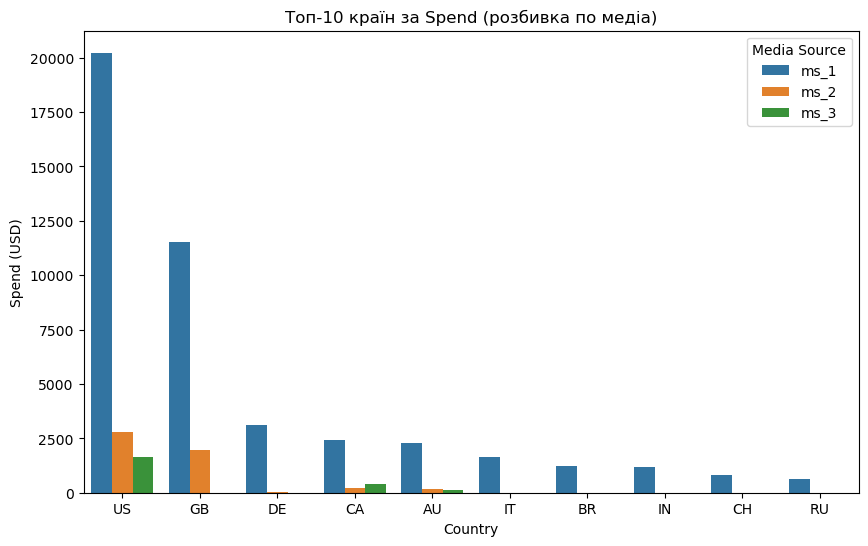

In [9]:
top10_spend = df_pivot.nlargest(10, "total_spend")
df_long = top10_spend.melt(
    id_vars=["country_code", "total_spend"],
    value_vars=["spend_usd_ms_1", "spend_usd_ms_2", "spend_usd_ms_3"],
    var_name="media_source",
    value_name="spend_usd"
)
df_long["media_source"] = df_long["media_source"].str.replace("spend_usd_", "")
plt.figure(figsize=(10,6))
sns.barplot(
    data=df_long,
    x="country_code", 
    y="spend_usd", 
    hue="media_source"
)
plt.title("Топ-10 країн за Spend (розбивка по медіа)")
plt.ylabel("Spend (USD)")
plt.xlabel("Country")
plt.legend(title="Media Source")
plt.show()

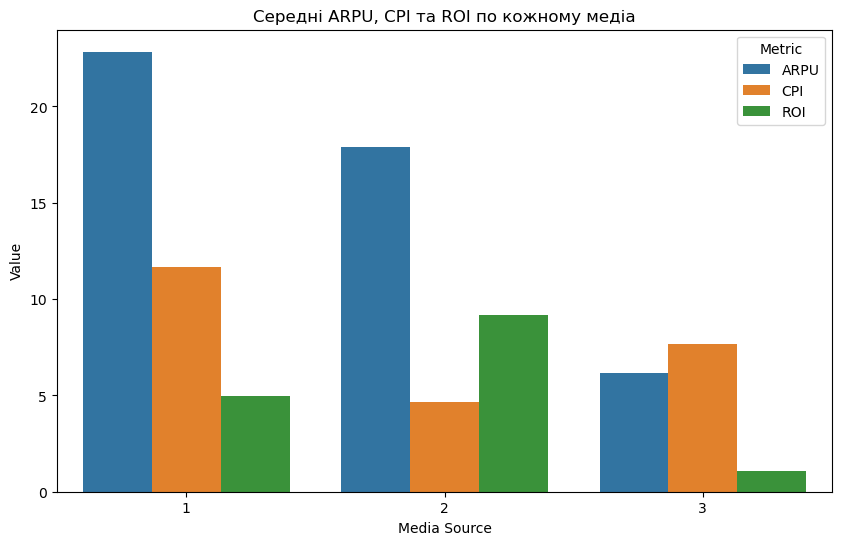

In [10]:
metrics = ["ARPU", "CPI", "ROI"]

rows = []
for metric in metrics:
    cols = [col for col in df_high_roi.columns if col.startswith(metric)]
    means = df_high_roi[cols].replace(0, np.nan).mean()
    for col, val in means.items():
        media = col.split("_")[-1]
        rows.append({"media_source": media, "metric": metric, "value": val})

df_avg = pd.DataFrame(rows)

plt.figure(figsize=(10,6))
sns.barplot(data=df_avg, x="media_source", y="value", hue="metric")
plt.title("Середні ARPU, CPI та ROI по кожному медіа")
plt.ylabel("Value")
plt.xlabel("Media Source")
plt.legend(title="Metric")
plt.show()


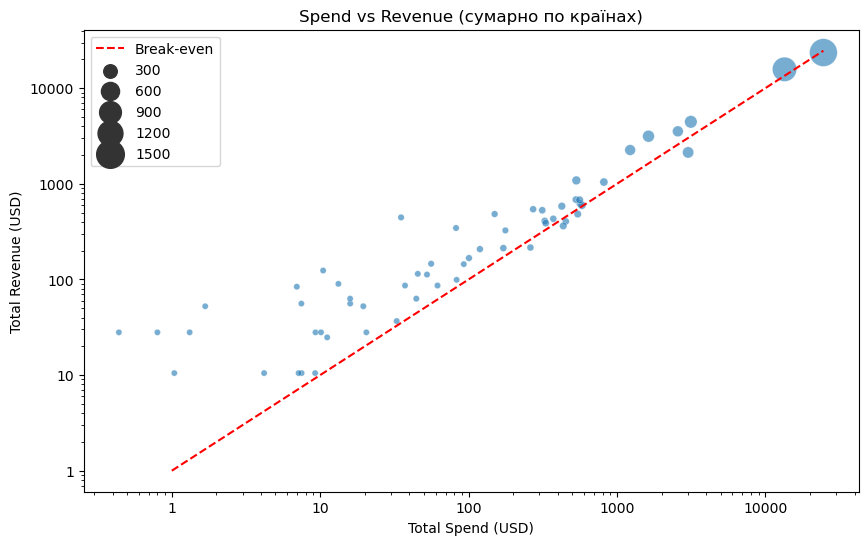

In [11]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df_high_roi,
    x="total_spend", 
    y=df_high_roi["revenue_ms_1"] + df_high_roi["revenue_ms_2"] + df_high_roi["revenue_ms_3"],
    size=df_high_roi["subscribers_ms_1"] + df_high_roi["subscribers_ms_2"] + df_high_roi["subscribers_ms_3"], 
    sizes=(20,400),
    alpha=0.6
)

plt.plot([1, df_high_roi["total_spend"].max()],
         [1, df_high_roi["total_spend"].max()],
         color="red", linestyle="--", label="Break-even")

plt.title("Spend vs Revenue (сумарно по країнах)")
plt.xlabel("Total Spend (USD)")
plt.ylabel("Total Revenue (USD)")
plt.legend()

plt.xscale("log")
plt.yscale("log")
plt.gca().xaxis.set_major_formatter(mticker.ScalarFormatter())
plt.gca().yaxis.set_major_formatter(mticker.ScalarFormatter())
plt.gca().ticklabel_format(style='plain', axis='both')

plt.show()


Висновки:

1. Оптимізація бюджетів: У країнах, де ROI по всіх медіа-сорсах нижче 1, доцільно забрати бюджет або переглянути стратегію просування. Це допоможе уникнути збитків та використати інвестиції більш доцільно

2. Фокус на ефективні медіа. Варто концентрувати бюджети на ті медіа, які демонструють найвищий ROI. Однак, якщо високий ROI спостерігається при малих витратах, ці результати варто додатково дослідити, так як можливий вплив випадковості, але також може бути потенціал для масштабування.

3. Переливання бюджетів: Рекомендується збільшувати бюджети у медіа з найкращим ROI, особливо якщо паралельно інші медіа показують ROI < 1. Це дозволить підвищити загальну ефективність інвестицій.

4. Для аналізу зміни стратегій побудувати прогноз ROI при можливому збільшенні бюджетів у медіа з найвищою ефективністю.


5. Провести A/B тестування з поступовим масштабуванням або зі зміною стратегії у країнах з потенціалом.


6. Встановити контрольні метрики (наприклад, мінімальний ROI на рівні 1.2) для швидкого прийняття рішень про зупинку чи оптимізацію кампаній.

In [152]:
def get_recommendation(row, threshold=0.5):
    rois = [row["ROI_ms_1"], row["ROI_ms_2"], row["ROI_ms_3"]]
    spends = [row["spend_usd_ms_1"], row["spend_usd_ms_2"], row["spend_usd_ms_3"]]
    total_spend = sum(spends)
    
    if all(r < 1 for r in rois):
        return "Забрати бюджет / змінити стратегію"
    
    if any(0 < r < 1 for r in rois) and any(r > 1 for r in rois):
        return "Змістити бюджет у прибуткові джерела"
    
    max_roi = max(rois)
    for r, s in zip(rois, spends):
        if total_spend > 0 and (s / total_spend) >= threshold and r < max_roi:
            return "Оптимізувати бюджет"
    
    return "OK"

df_pivot["recommendation"] = df_pivot.apply(get_recommendation, axis=1)

df_pivot.to_excel("df_pivot_with_recommendations.xlsx", index=False)

Додано колонку "recommendation" та збережено в df 'df_pivot_with_recommendations', у якій для кожної країни сформульовано рекомендації щодо подальшої стратегії.

У ній враховано:

якщо всі медіа мають ROI нижче 1 - пропонується зупинити інвестиції або змінити підхід;

чи є медіа з низьким ROI по одних медіа та високим ROI по інших одночасно - рекомендація змістити бюджет у більш прибуткові джерела;

якщо частина бюджету зосереджена у медіа з великими витратами, але гіршим ROI, ніж у інших - пропонується оптимізація

Таким чином, кожен рядок відображає індивідуальну оцінку для країни з урахуванням ефективності витрат і прибутковості каналів.

In [12]:
arpu_cols = [c for c in df_pivot.columns if c.startswith("ARPU_")]
df_pivot["avg_arpu"] = df_pivot[arpu_cols].mean(axis=1, skipna=True)

df_high_spend_high_arpu = (
    df_pivot[df_pivot["total_spend"] > 1000]
    .sort_values("avg_arpu", ascending=False)
    [["country_code", "avg_arpu", "total_spend"]]
)

df_high_spend_high_arpu.head(10) 


,country_code,avg_arpu,total_spend
210,US,13.976325,24644.934872
10,AU,13.969449,2574.972308
48,DE,13.126654,3149.184319
32,CA,8.898393,3018.892882
66,GB,8.537370,13475.027212
95,IT,4.994437,1632.188675
26,BR,4.700996,1228.120687
92,IN,1.944595,1167.665420


Також перспективними точками для зростання є країни з високим ARPU. Високий ARPU свідчить про платоспроможність користувачів і їхню зацікавленість у продукті. Навіть за умови, що CPI водночас залишається відносно високим, варто розглянути можливості його зниження, наприклад шляхом оптимізації конверсії існуючих каналів або пошуку більш доступних медіа.